# Imports

In [1]:
import heapq
import pickle
import pathlib
import operator
import tabulate
import itertools
import collections

In [2]:
import nltk
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
from nltk.corpus import wordnet as wn
from sklearn.base import BaseEstimator, TransformerMixin

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'
SPACY_DATA = DATA_DIR / 'spacy_data'

# Classes

## PickledCorpusReader

In [5]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [6]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids
    
    def feeds(self):
        data = self.open('feeds.json')
        return json.load(data)

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def tagged_paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for tagged_para in doc:
                yield tagged_para
    
    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of tokens.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            yield [[word for word, tag in tagged_sent]
                   for tagged_sent in tagged_para]

    def tagged_sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            for tagged_sent in tagged_para:
                yield tagged_sent
                
    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        tokens.
        """
        for tagged_sent in self.tagged_sents(fileids, categories):
            yield [word for word, tag in tagged_sent]
    
    def tagged_words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.tagged_sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of tokens.
        """
        for word, tag in self.tagged_words(fileids, categories):
            yield word
    
    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()
        
        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1
            
            for sent in para:
                counts['sents'] += 1
                
                for word, tag in sent:
                    counts['words'] += 1
                    tokens[word] += 1
        
        # Compute the number of files and categories in the corpus
        n_fileids = len(self._resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self._resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': counts['words'] / len(tokens),
            'ppdoc':  counts['paras'] / n_fileids,
            'sppar':  counts['sents'] / counts['paras'],
            'secs':   time.time() - started,
        }

In [7]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words = collections.Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

58,748 vocabulary 1,624,862 word count


## NLTKEntityExtractor

In [8]:
NLTK_LABELS = frozenset([
    'PERSON', 'ORGANIZATION', 'FACILITY', 'GPE', 'GSP'
])

In [9]:
class NLTKEntityExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, labels=NLTK_LABELS):
        self.labels = labels
        
    def get_entities(self, document):
        return [
            ' '.join(word.lower() for word, tag in tree)
            for paragraph in document
            for sentence in paragraph
            for tree in nltk.ne_chunk(sentence)
            if hasattr(tree, 'label')
            and tree.label() in self.labels
        ]
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            yield self.get_entities(document)

## SpacyEntityExtractor

In [10]:
SPACY_LABELS = frozenset([
    'PERSON', 'NORP', 'FACILITY', 'ORG', 'GPE', 'LOC',
    'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE'
])

In [11]:
class SpacyEntityExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, model_path, labels=SPACY_LABELS):
        self.model_path = model_path
        self.labels = labels
    
    def get_entities(self, model, document):
        return [
            entity.text
            for paragraph in document
            for sentence in paragraph
            for entity in (
                model(' '.join(word for word, tag in sentence)).ents
            )
            if entity.label_ in self.labels
        ]
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        model = spacy.load(self.model_path)
        for document in documents:
            yield self.get_entities(model, document)

# Graph Computation and Analysis

## Creating a Graph-Based Thesaurus

In [12]:
def graph_synsets(terms, pos=wn.NOUN, depth=2):
    """
    Create a networkx graph of the given terms to the given depth.
    """

    G = nx.Graph(
        name=f"WordNet Synsets Graph for {', '.join(terms)}",
        depth=depth
    )

    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                if term != name:
                    G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth + 1)

    for term in terms:
        add_term_links(G, term, 0)

    return G

In [13]:
G = graph_synsets(['trinket'])
print(G)

Graph named 'WordNet Synsets Graph for trinket' with 25 nodes and 39 edges


## Analyzing Graph Structure

In [14]:
nx.diameter(G)

5

## Visual Analysis of Graphs

In [15]:
def draw_text_graph(G, figsize=(18, 12)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos,
                           node_color='white',
                           linewidths=0,
                           node_size=500)
    nx.draw_networkx_labels(G, pos,
                            font_size=10)
    nx.draw_networkx_edges(G, pos)

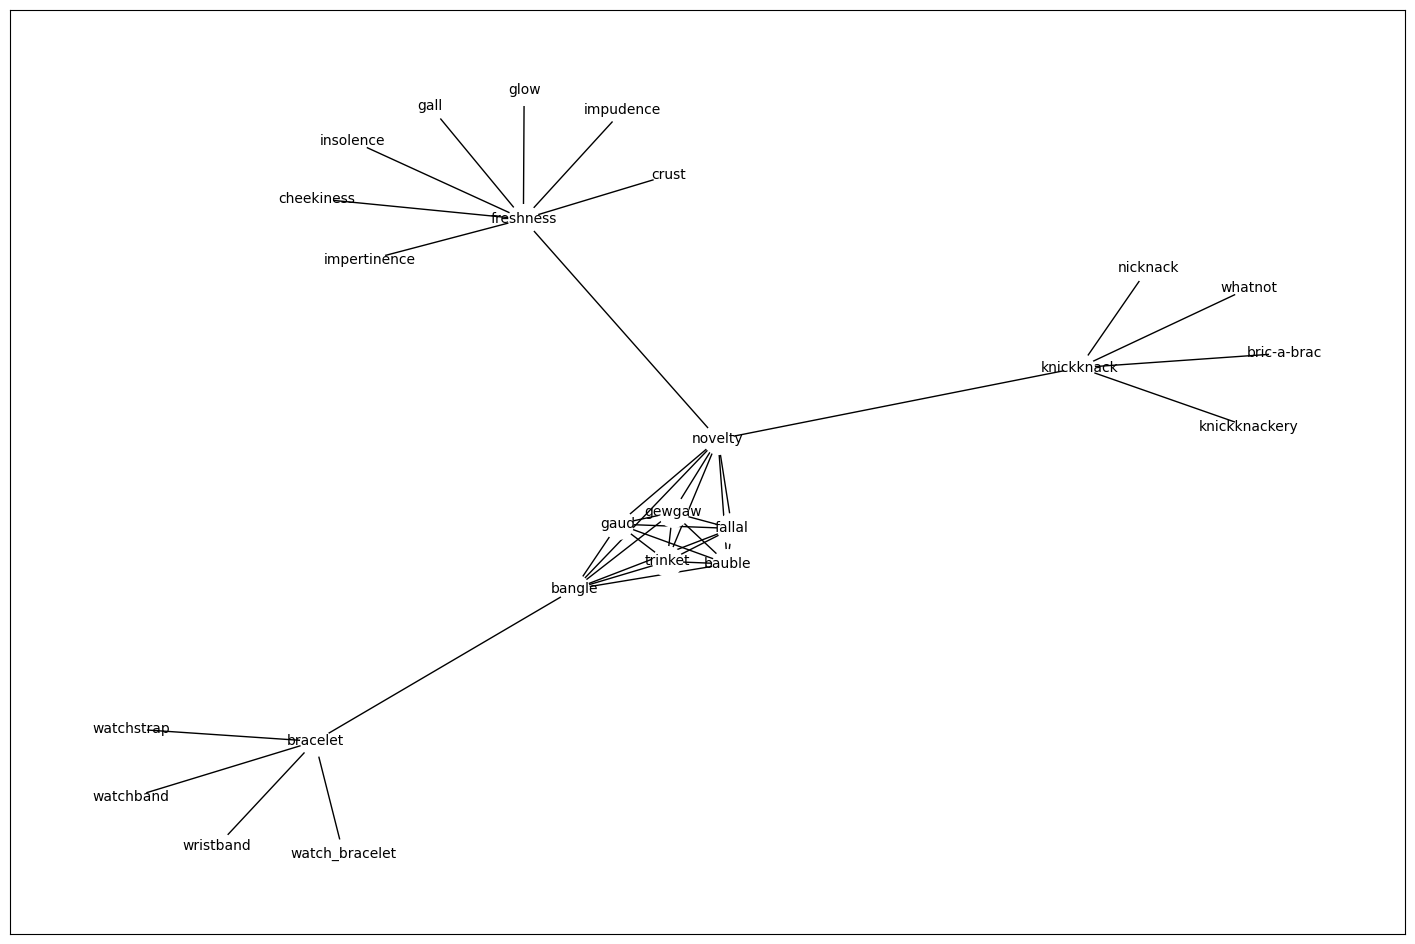

In [16]:
draw_text_graph(G)
plt.show()

# Extracting Graphs from Text

## Creating a Social Graph

### Finding entity pairs

In [17]:
class EntityPairs(BaseEstimator, TransformerMixin):
    
    def pairs(self, document):
        # return list(itertools.combinations(set(document), 2))
        return itertools.combinations(set(document), 2)
    
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        # return [self.pairs(document) for document in documents]
        for document in documents:
            yield self.pairs(document)

### Property graphs

### Implementing the graph extraction

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
class GraphExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.G = nx.Graph()
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first, second) in self.G.edges():
                    self.G.edges[(first, second)]['weight'] += 1
                else:
                    self.G.add_edge(first, second, weight=1)
        return self.G

In [20]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
docs = corpus.docs()

In [21]:
graph = Pipeline([
    ('entities', NLTKEntityExtractor()),
    # ('entities', SpacyEntityExtractor(SPACY_DATA / 'en_core_web_sm')),
    ('pairs', EntityPairs()),
    ('graph', GraphExtractor())
])

In [33]:
%%time
G = graph.fit_transform(docs)

CPU times: user 490 µs, sys: 0 ns, total: 490 µs
Wall time: 498 µs


In [35]:
print(G)

Graph with 29176 nodes and 1232644 edges


## Insights from the Social Graph

### Centrality

In [24]:
def nbest_centrality(G, metric, n=10, attr='centrality', **kwargs):
    # Compute the centrality scores for each vertex
    scores = metric(G, **kwargs)

    # Set the score as a property on each node
    nx.set_node_attributes(G, name=attr, values=scores)

    # Find the top n scores
    topn = heapq.nlargest(
        n=n,
        iterable=scores.items(),
        key=operator.itemgetter(1)
    )
    
    # Print them along with their index
    print("Rankings for {}:".format(attr))
    print(tabulate.tabulate(
        tabular_data=topn, 
        headers=['Top Terms', 'Score'],
        floatfmt='.4f',
        showindex=range(1, len(topn) + 1)
    ))

    return G

In [26]:
%%time
G = nbest_centrality(G, nx.degree_centrality, attr='degree_centrality')

Rankings for degree_centrality:
    Top Terms        Score
--  -------------  -------
 1  american        0.2243
 2  new york        0.2145
 3  washington      0.1610
 4  america         0.1567
 5  united states   0.1531
 6  los angeles     0.1395
 7  republican      0.1301
 8  california      0.1206
 9  trump           0.1168
10  twitter         0.1144
CPU times: user 46.6 ms, sys: 5.01 ms, total: 51.6 ms
Wall time: 48.2 ms


In [43]:
%%time
G = nbest_centrality(G, nx.betweenness_centrality, attr='betweenness_centrality')

Rankings for betweenness_centrality:
    Top Terms        Score
--  -------------  -------
 1  american        0.0541
 2  new york        0.0501
 3  america         0.0258
 4  united states   0.0246
 5  washington      0.0244
 6  los angeles     0.0229
 7  twitter         0.0192
 8  follow          0.0182
 9  california      0.0181
10  new             0.0181
CPU times: user 2h 51min 8s, sys: 28.1 ms, total: 2h 51min 8s
Wall time: 2h 51min 8s


In [45]:
H = nx.ego_graph(G, 'hollywood')

In [46]:
print(H)

Graph with 2572 nodes and 237818 edges


In [49]:
%%time
H = nbest_centrality(H, nx.closeness_centrality, attr='closeness_centrality')

Rankings for closeness_centrality:
    Top Terms      Score
--  -----------  -------
 1  hollywood     1.0000
 2  new york      0.6878
 3  los angeles   0.6511
 4  british       0.6356
 5  america       0.6292
 6  american      0.6252
 7  video         0.6213
 8  london        0.6129
 9  china         0.6124
10  brooklyn      0.6072
CPU times: user 3.22 s, sys: 2 ms, total: 3.22 s
Wall time: 3.22 s


In [56]:
%%time
H = nbest_centrality(H, nx.eigenvector_centrality_numpy, attr='eigenvector_centrality_numpy')

Rankings for eigenvector_centrality_numpy:
    Top Terms        Score
--  -------------  -------
 1  hollywood       0.0510
 2  new york        0.0493
 3  los angeles     0.0485
 4  british         0.0480
 5  video           0.0480
 6  china           0.0479
 7  london          0.0478
 8  twitter         0.0477
 9  new york city   0.0477
10  new             0.0476
CPU times: user 530 ms, sys: 19 ms, total: 549 ms
Wall time: 418 ms


In [60]:
%%time
H = nbest_centrality(H, nx.pagerank, attr='pagerank')

Rankings for pagerank_numpy:
    Top Terms        Score
--  -------------  -------
 1  hollywood       0.0071
 2  american        0.0058
 3  new york        0.0056
 4  trump           0.0052
 5  republican      0.0052
 6  america         0.0048
 7  donald trump    0.0046
 8  washington      0.0042
 9  united states   0.0040
10  obama           0.0038
CPU times: user 403 ms, sys: 14 ms, total: 417 ms
Wall time: 414 ms


In [65]:
%%time
%%capture --no-stdout
H = nbest_centrality(H, nx.katz_centrality_numpy, attr='katz_centrality_numpy')

Rankings for katz_centrality_numpy:
    Top Terms             Score
--  ------------------  -------
 1  video                0.1076
 2  washington           0.1042
 3  chinese              0.1035
 4  hillary              0.0893
 5  cleveland            0.0877
 6  state                0.0876
 7  muslims              0.0840
 8  editor               0.0819
 9  paramount pictures   0.0802
10  republican party     0.0788
CPU times: user 1.5 s, sys: 121 ms, total: 1.62 s
Wall time: 643 ms


### Structural analysis

# Entity Resolution

## Entity Resolution on a Graph

## Blocking with Structure

## Fuzzy Blocking